# Loading Libraries

In [47]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from torchvision import transforms
from PIL import Image

device = ('cuda' if torch.cuda.is_available() else 'cpu')

hparams = {
    'batch_size': 32,
    'use_l2_reg': True,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'log_interval': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Define the CustomCNN

In [48]:
# Custom CNN Architecture with Batch Normalization, and Dropout options
class CustomCNN(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False):
        super(CustomCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the size according to your input image dimensions
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x) if self.use_batch_norm else x
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.use_batch_norm else x
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x) if self.use_dropout else x

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x) if self.use_batch_norm else x
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x) if self.use_batch_norm else x
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x) if self.use_dropout else x

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x) if self.use_batch_norm else x
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x) if self.use_batch_norm else x
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x) if self.use_dropout else x

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x) if self.use_dropout else x
        x = self.fc2(x)

        return x

## Define training and testing functions

In [49]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams):
    network.train()
    device = hparams['device']
    avg_loss = None
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if avg_loss:
            avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
            avg_loss = loss.item()
        if batch_idx % hparams['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            acc += correct_predictions(output, target)
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {acc}/{len(test_loader.dataset)} ({test_acc:.0f}%)\n')
    return test_loss, test_acc

def plot_and_save_results(tr_losses, te_losses, te_accs, experiment_num):
    # Plotting Training and Testing Losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='blue')
    plt.plot(te_losses, label='Testing Loss', color='red')
    plt.title(f'Training and Testing Loss Over Epochs - Experiment {experiment_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(te_accs, label='Testing Accuracy', color='green')
    plt.title(f'Testing Accuracy Over Epochs - Experiment {experiment_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f"transfer_{experiment_num}_results.png")

    # Show the plot
    plt.show()

# Function to run an experiment
def run_training(trainloader, testloader, network, experiment_num=1, batch_size=hparams['batch_size'], use_l2_reg=False):
    # Update hyperparameters based on the experiment
    optimizer_weight_decay = 0.001 if use_l2_reg else 0
    
    # Calculate the total number of trainable parameters
    total_params = count_parameters(network)
    print(f"Total trainable parameters in the model: {total_params}")
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

    # Define the optimizer with or without L2 regularization
    optimizer = optim.Adam(network.parameters(), lr=hparams['learning_rate'], weight_decay=optimizer_weight_decay)

    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Training and validation loop
    tr_losses, te_losses, te_accs = [], [], []
    
    # Start the timer
    start_time = time.time()

    for epoch in range(1, hparams['num_epochs'] + 1):
        tr_losses.append(train_epoch(epoch, trainloader, network, optimizer, criterion, hparams))
        te_loss, te_acc = test_epoch(testloader, network, hparams)
        te_losses.append(te_loss)
        te_accs.append(te_acc)
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)

    print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s')
    
    plot_and_save_results(tr_losses, te_losses, te_accs, experiment_num)

    return network


## Load Terrassa 900 dataset

In [50]:
class TerrassaDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.data = self._load_data()
        self.class_to_idx = self._get_class_to_idx()

    def _load_data(self):
        data = []
        annotation_file_path = os.path.join(self.root_dir, self.split, 'annotation.txt')

        with open(annotation_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                image_id, class_name = line.strip().split()
                image_path = os.path.join(self.root_dir, self.split, 'images', f'{image_id}.jpg')
                data.append((image_path, class_name))

        return data

    def _get_class_to_idx(self):
        classes = set([item[1] for item in self.data])
        class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
        return class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, class_name = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.class_to_idx[class_name])
        return image, label
    
    
# Set the path to your dataset

# Get the current working directory
current_dir = os.getcwd()

# Go back one directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Combine with 'terrassa' to get the desired path
dataset_root = os.path.join(parent_dir, 'terrassa')


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms (you may customize this based on your needs)
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])


# Create train and test datasets
train_dataset = TerrassaDataset(root_dir=dataset_root, split='train', transform=transform)
test_dataset = TerrassaDataset(root_dir=dataset_root, split='test', transform=transform)
val_dataset = TerrassaDataset(root_dir=dataset_root, split='val', transform=transform)

# Concatenate the original trainset with the augmented dataset (70% of all data)
combined_trainset = ConcatDataset([train_dataset, val_dataset])


# Create data loaders
terrassa_train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
terrassa_test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)


torch.Size([32, 3, 32, 32]) torch.Size([32])


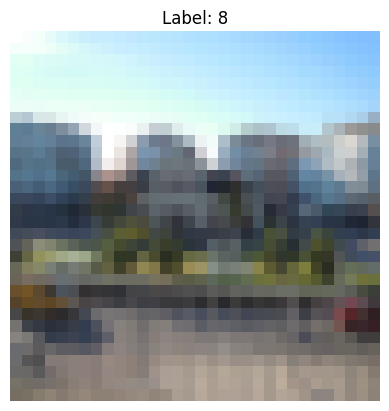

In [69]:
for images, labels in train_loader:
  print(images.size(), labels.size())
  break
    
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Transformation for visualization (undo normalization)
inv_normalize = transforms.Normalize(
    mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]],
    std=[1 / std[0], 1 / std[1], 1 / std[2]]
)


# Function to display an image
def show_image(img, title):
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)  # Clip values to stay within valid range
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image from the batch
show_image(images[0], title=f"Label: {labels[0]}")

# 1. Custom CNN over Terrassa 900

In [26]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is B688-6E24

 Directory of C:\Users\pauco\OneDrive\Documentos\DOCUMENTS\JUPYTER\block3_AML\notebooks

07/01/2024  11:31    <DIR>          .
07/01/2024  11:06    <DIR>          ..
07/01/2024  10:27    <DIR>          .ipynb_checkpoints
07/01/2024  09:47           523.723 1_Baseline_CNN_CIFAR.ipynb
07/01/2024  09:57           912.996 2_Experiments.ipynb
07/01/2024  10:23         4.215.660 3_Interpretability.ipynb
07/01/2024  11:31            15.187 4_Transfer learning.ipynb
07/01/2024  09:44         2.223.323 custom_cnn_model.pth
07/01/2024  09:44         2.223.323 custom_cnn_model_best_task2.pth
07/01/2024  09:44    <DIR>          old_tries
               6 File(s)     10.114.212 bytes
               4 Dir(s)  339.045.879.808 bytes free


# 2. Custom CNN on CIFAR-10 as a feature extractor for Terrassa 900

### Load custom_cnn_model_best_task2 model weights from Task 2

In [17]:
network = CustomCNN(use_batch_norm=True, use_dropout=True)
model_path = "custom_cnn_model_best_task2.pth"
network.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>